# **Código de prueba para Interpolación**
Tomado de: http://carina.fcaglp.unlp.edu.ar/mpp/notebooks/ajuste_tendencia_ccaSalado.html

In [1]:
import numpy as np                     # para calcular, NUMerical PYthon.
import matplotlib.pyplot as plt        # para graficar, matplotlib.
import pandas as pd                    # para leer datos, PYthon Data Analysis.

In [28]:
# para pasar datos de csv a geodataframe.
import modules.data_gdf as data_gdf


In [29]:
data_sensor = pd.read_csv("data/datoshoy.txt", encoding='unicode_escape')


In [31]:
data_media = data_gdf.data_gdf_media("data/datoshoy.txt")


c:\Users\Migue Polo\OneDrive - Universidad del Magdalena\SistemasInteligentes\kriging\modules\data_gdf.py:65: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data_media = gdf.groupby("Muestra").mean()


<AxesSubplot: >

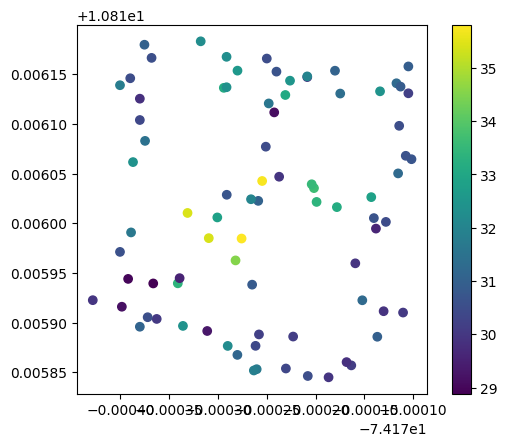

In [32]:
data_media.plot("Temperatura Suelo", legend=True)

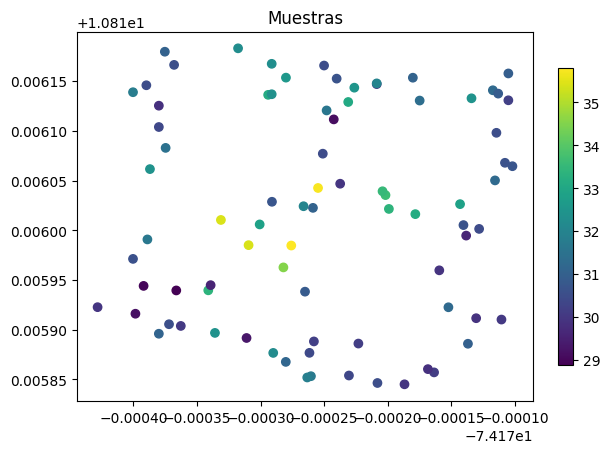

In [33]:
# Gráfico (simplificado)
plt.figure()
cax = plt.scatter(data_media["Longitud"], data_media["Latitud"], c=data_media["Temperatura Suelo"])
cbar = plt.colorbar(cax, fraction=0.03)
plt.title('Muestras')
plt.show()


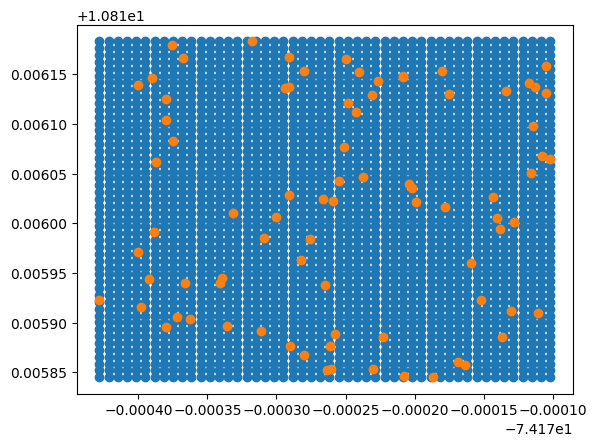

In [45]:
# Construcción de la grilla
nx, ny = 50, 50
x = data_media["Longitud"]
y = data_media["Latitud"]
grid_x = np.linspace(min(x), max(x), nx)
grid_y = np.linspace(min(y), max(y), ny)
X, Y = np.meshgrid(grid_x, grid_y)

# Gráfico (simplificado)
plt.figure()
plt.scatter(X, Y)
plt.scatter(x, y)
plt.show()


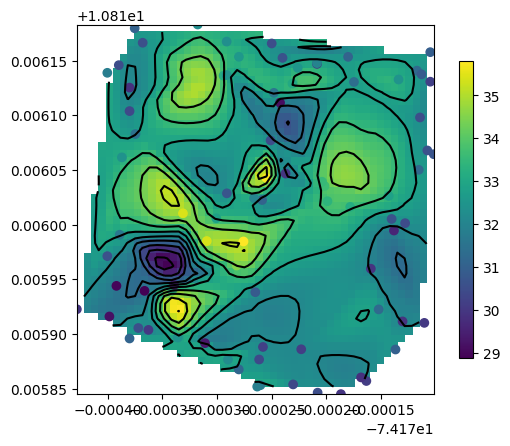

In [47]:
from scipy.interpolate import griddata

GZ = griddata(points=(x, y), values=data_media["Temperatura Suelo"], xi=(
    X, Y), method='cubic', fill_value=np.nan)
# Si se coloca np.nan en vez de 0, se ve mejor el gráfico.
# Debido a que sólo se grafican los puntos, no la grilla.

# Gráfico (simplificado)
plt.figure()
plt.contour(X, Y, GZ, 10, colors='black')
plt.imshow(GZ, origin="lower", interpolation=None, extent=[
           np.min(x), np.max(x), np.min(y), np.max(y)])
cax2 = plt.scatter(x, y, c=data_media["Temperatura Suelo"])
cbar2 = plt.colorbar(cax2, fraction=0.03)
plt.show()


# Ajuste de polinomios de tendencia

In [48]:
# Caso M = 1:  m = (a,b,c)^T es 3x1
m = np.zeros(shape=(3, 1))
A = np.zeros(shape=(len(data_media["Temperatura Suelo"]), len(m)))
A[:, 0] = x
A[:, 1] = y
A[:, 2] = np.ones(len(data_media["Temperatura Suelo"]))


In [49]:
from scipy.linalg import lstsq

m, _, _, _ = lstsq(A, data_media["Temperatura Suelo"])


# Interpolación de la superficie de tendencia sobre la grilla rectangular

In [50]:
nx = len(grid_x)
ny = len(grid_y)
A_grid = np.zeros(shape=(nx*ny, len(m)))
# Caso M = 1
A_grid[:, 0] = X.reshape(nx*ny)
A_grid[:, 1] = Y.reshape(nx*ny)
A_grid[:, 2] = np.ones(nx*ny)

In [51]:
GZ_fit = A_grid @ m # En Python>3, '@' es el producto entre una matriz y un vector
GZ_res = GZ - GZ_fit.reshape(nx,ny) # campo residual interpolado

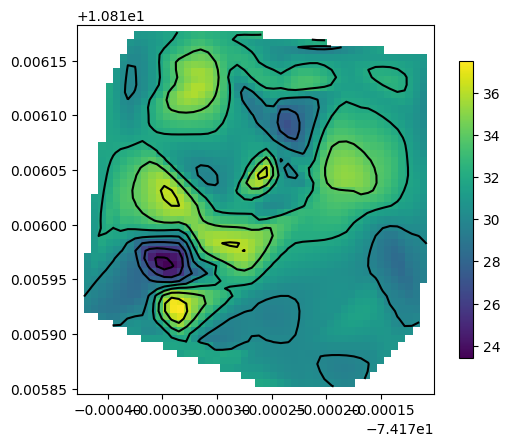

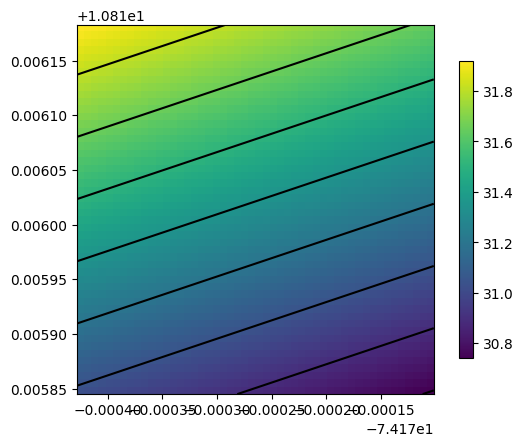

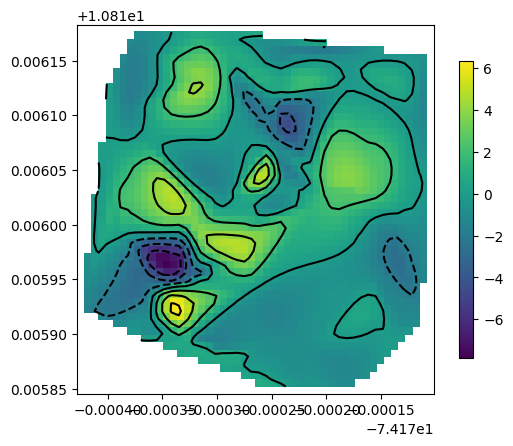

In [54]:
# Gráficos (simplificado):
for GRILLA in [GZ, GZ_fit.reshape(nx,ny), GZ_res]:
    plt.figure()
    plt.contour(X, Y, GRILLA, colors="black")
    plt.imshow(GRILLA, origin="lower", interpolation=None, extent=[np.min(x),np.max(x),np.min(y),np.max(y)])
    plt.colorbar(fraction=0.03)
    plt.show()


# **Pruebas con Kriging**

Plotting Enabled

Initializing variogram model...
Coordinates type: 'geographic' 

Using 'hole-effect' Variogram Model
Partial Sill: 2.093418066052539
Full Sill: 2.093426385718599
Range: 0.00016035292595529565
Nugget: 8.319666059665576e-06 



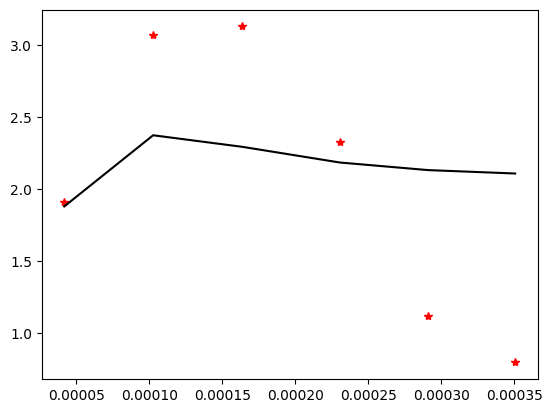

Calculating statistics on variogram model fit...


In [104]:
from pykrige.ok import OrdinaryKriging
variogram_model = "hole-effect"
coordinates_type = "geographic"
OK = OrdinaryKriging(
    x,
    y,
    data_media["Temperatura Suelo"],
    variogram_model=variogram_model,
    verbose=True,
    coordinates_type=coordinates_type,
    enable_plotting=True,
)



In [105]:
OK.variogram_model_parameters

array([2.09341807e+00, 1.60352926e-04, 8.31966606e-06])

In [122]:
zstar, ss = OK.execute("grid", grid_x, grid_y)

Executing Ordinary Kriging...



In [139]:
print(zstar.shape)
print(ss.shape)

(50, 50)
(50, 50)


Text(0.5, 1.0, 'Temperatura del suelo')

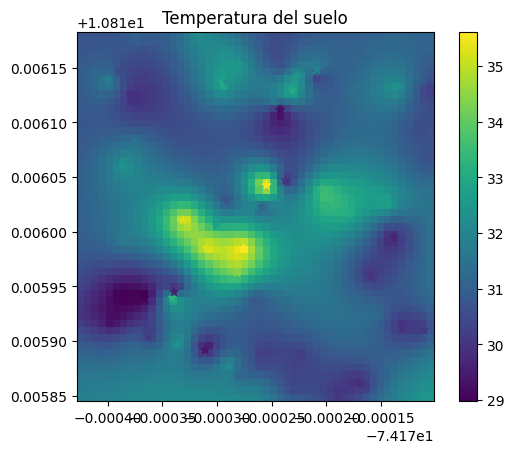

In [124]:
cax = plt.imshow(zstar, extent=(
    min(x), max(x), min(y), max(y)), origin='lower')
plt.scatter(x, y, c=data_media["Temperatura Suelo"], marker='*')
cbar = plt.colorbar(cax)
plt.title('Temperatura del suelo')


In [135]:
from rasterio.transform import Affine
import rasterio

In [150]:
transform = rasterio.transform.from_bounds(min(x), min(y), max(x), max(y), nx, ny)
transform

Affine(6.527999999832446e-06, 0.0, -74.17042819999999,
       0.0, -6.760000000021193e-06, 10.816183)

In [153]:
new_dataset = rasterio.open(
    'new2.tiff',
    'w',
    driver='GTiff',
    height=zstar.shape[0],
    width=zstar.shape[1],
    count=1,
    dtype=zstar.dtype,
    crs={"init": "EPSG:4326"},
    transform=transform,
)


In [148]:
new_dataset.write(zstar, 1)

In [149]:
new_dataset.close()

Text(0.5, 1.0, 'Temperatura del suelo')

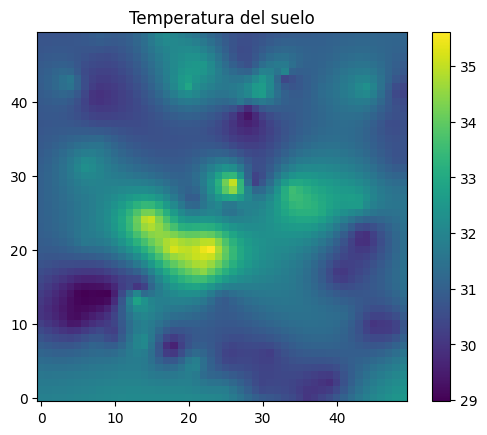

In [132]:
cax = plt.imshow(zstar, origin='lower')
# plt.scatter(x, y, c=data_media["Temperatura Suelo"], marker='*')
cbar = plt.colorbar(cax)
plt.title('Temperatura del suelo')


ValueError: 'c' argument has 2500 elements, which is inconsistent with 'x' and 'y' with size 82.

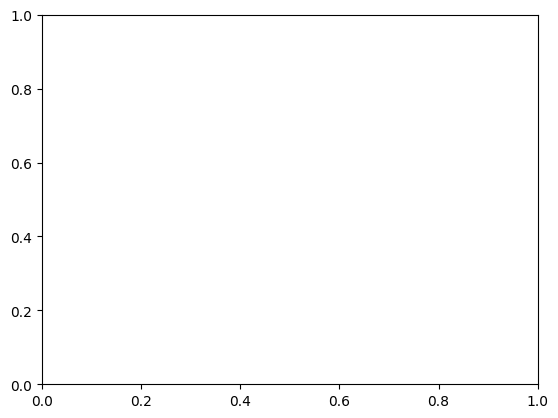

In [116]:
# Gráfico (simplificado)
plt.figure()
cax = plt.scatter(data_media["Longitud"], data_media["Latitud"], c=zstar)
cbar = plt.colorbar(cax, fraction=0.03)
plt.title('Muestras')
plt.show()


Text(0.5, 1.0, 'Desviación estándar temperatura del suelo')

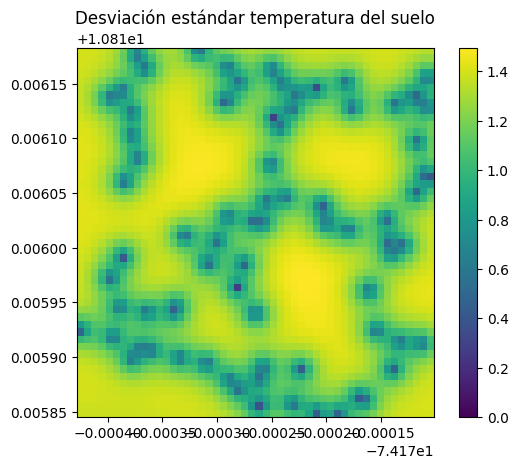

In [158]:
cax = plt.imshow(np.sqrt(ss), extent=(
    min(x), max(x), min(y), max(y)),
    origin='lower', vmin=0)
# plt.scatter(x, y, c='k', marker='.')
cbar = plt.colorbar(cax)
plt.title('Desviación estándar temperatura del suelo')


In [110]:
OK.variogram_model_parameters

array([2.09341807e+00, 1.60352926e-04, 8.31966606e-06])